In [1]:
#essential libraries
import numpy as np
import pandas as pd
from scipy.cluster.vq import *
import operator
import matplotlib
reload(matplotlib)
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import pickle
import shelve
import re
from collections import Counter, defaultdict, OrderedDict, deque
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics#v_measure_scorez
import scipy
from sklearn.feature_extraction import DictVectorizer
from matplotlib.backends.backend_pdf import PdfPages
import csv
import sys
import math
from copy import deepcopy, copy
import random

from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import OneClassSVM
from sklearn.mixture import GMM
from sklearn.mixture import DPGMM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as hier
from scipy.cluster.hierarchy import fcluster
from scipy import spatial

#%matplotlib inline

from divergence import gau_js as js_divergence

In [2]:
def save_fig(fig, name, dpi=400):
	pp = PdfPages(name)
	pp.savefig(fig, bbox_inches='tight', pad_inches=0, dpi=dpi)
	pp.close()

In [3]:
sensor_dict = shelve.open('metadata/bacnet_devices.shelve','r')

In [4]:
buildingName = 'ebu3b'

featureFilename = 'data/fe_' + buildingName + '.pkl'
with open(featureFilename, 'rb') as fp:
    featureDict = pickle.load(fp)
columnNames = ['max', 'min', 'mean', 'amp', 'std', 'dominating freq', 'paa', 'pla', 'fluxpercentilemid20', 'meanvariance', 'oom', 'sgfilt']
#featureDF = pd.concat([pd.DataFrame(data=featureDict.keys(), columns=['srcid']),pd.DataFrame(data = featureDict.values(), columns = columnNames)], axis=1)
featureDF = pd.DataFrame(data = featureDict.values(), columns = columnNames, index=featureDict.keys())
#for key, series in featureDF.iteritems():
#    tempList = list()
#    for k, v in series.iterkv():
#        if np.isnan(v):
#            #print "hello"
#            #series[i] = -999999
#            series[k] = -999999
#    print key
    #featureDF[key] = pd.Series(tempList)

naeDict = dict()
naeDict['bonner'] = ["607", "608", "609", "557", "610"]
naeDict['ap_m'] = ['514', '513','604']
naeDict['bsb'] = ['519', '568', '567', '566', '564', '565']
naeDict['ebu3b'] = ["505", "506"]
naeList = naeDict[buildingName]

labeledFile = 'metadata/' + buildingName + '_sensor_types_location.csv'
with open(labeledFile, 'rb') as fp:
    #truthDF = pd.read_excel(fp)
    truthDF = pd.DataFrame.from_csv(fp)
    truthDF = truthDF.set_index(keys='Unique Identifier')
    
wordRoleFile = 'metadata/' + buildingName + '_word_roles.csv'
with open(wordRoleFile, 'rb') as fp:
    #truthDF = pd.read_excel(fp)
    wordroleDF = pd.DataFrame.from_csv(fp)
    

In [5]:
columnNames = ['max', 'min', 'mean', 'amp', 'oom', 'std', 'paa', 'pla', 'dominating freq']#, 'paa', 'pla']#, 'dominating freq', 'paa', 'pla', 'fluxpercentilemid20', 'meanvariance', 'sgfilt']
featureDF = featureDF[columnNames]

In [6]:
# Vectorization

#Parse the data in the dictionary as filtered by device_list
#Gives us a sensor_list with sensor information of a building

def extract_words(sentence, delimiter):
    #result = re.findall('(\d+\s?-?\s?\d+)|(\d+)', sentence)
    result = sentence.lower().split(delimiter)
    while '' in result:
        result.remove('')
    return result

def sentence2lower(wordList):
    return [word.lower() for word in wordList]

sensor_list = []
nameList = list()
names_num_list = []
names_str_list = []
names_num_listWithDigits = [] 
sensor_type_namez=[]
descList = []
unitList = []
type_str_list = []
type_list = []
jcinameList = list()
jci_names_str_list = []
source_id_set = set([])

tokenType = 'NumAsSingleWord'
tokenTypeList = ['NoNumber', 'Alphanumeric', 'AlphaAndNum', 'NumAsSingleWord']


for nae in naeList:
    device = sensor_dict[nae]
    h_dev = device['props']
    for sensor in device['objs']:
        h_obj = sensor['props']
        source_id = str(h_dev['device_id']) + '_' + str(h_obj['type']) + '_' + str(h_obj['instance'])
        if not source_id in featureDF.index:
            continue
        
        if h_obj['type'] not in (0,1,2,3,4,5,13,14,19):
            continue
        
        if source_id in source_id_set:
            continue
        else:
            source_id_set.add(source_id)
        
        #nameList.append(' '.join(extract_words(sensor['name'], ' ')))
        #jcinameList.append(' '.join(extract_words(sensor['jci_name'], '.')))
        #descList.append(' '.join(extract_words(sensor['desc'], '.')))
        
        #nameList.append(sensor['name'])
        #jcinameList.append(sensor['jci_name'])
        #descList.append(sensor['desc'])
        
        #nameList.append(' '.join(re.findall("\w+", sensor['name'])))
        #jcinameList.append(' '.join(re.findall("\w+", sensor['jci_name'])))
        #descList.append(' '.join(re.findall("\w+", sensor['desc'])))
        
        if tokenType=='Alphanumeric':
            jciSentence = re.findall("\w+", sensor['jci_name'])
            nameSentence = re.findall("\w+", sensor['name'])
            descSentence = re.findall("\w+", sensor['desc'])
        elif tokenType in ['AlphaAndNum', 'NumAsSingleWord']:
            jciSentence = re.findall("[a-zA-Z]+|\d+", sensor['jci_name'])
            nameSentence = re.findall("[a-zA-Z]+|\d+", sensor['name'])
            descSentence = re.findall("[a-zA-Z]+|\d+", sensor['desc'])
        elif tokenType=='NoNumber':
            jciSentence = re.findall("[a-zA-Z]+|\d+", sensor['jci_name'])
            nameSentence = re.findall("[a-zA-Z]+|\d+", sensor['name'])
            descSentence =re.findall("[a-zA-Z]+|\d+", sensor['desc'])        
        else:
            assert(False)
        if tokenType=='NumAsSingleWord':
            jciSentence = ['NUM' if len(re.findall('\d+',word))>0 else word for word in jciSentence]
            nameSentence = ['NUM' if len(re.findall('\d+',word))>0 else word for word in nameSentence]
            descSentence = ['NUM' if len(re.findall('\d+',word))>0 else word for word in descSentence]
            
        jcinameList.append(' '.join(sentence2lower(jciSentence)))
        nameList.append(' '.join(sentence2lower(nameSentence)))
        descList.append(' '.join(sentence2lower(descSentence)))
        
        
        
        #nameSentence = ' '.join(re.findall("[a-zA-Z]+ | \d+", sensor['name']))
        #while len(re.findall('\d+', nameSentence))>0:
        #    nameSentence = nameSentence.replace(re.findall('\d+', nameSentence)[0], 'NUM')
        #jcinameSentence = ' '.join(re.findall("[a-zA-Z]+ | \d+", sensor['jci_name']))
        #while len(re.findall('\d+', jcinameSentence))>0:
        #    jcinameSentence = jcinameSentence.replace(re.findall('\d+', jcinameSentence)[0], 'NUM')
        #descSentence = ' '.join(re.findall("[a-zA-Z]+ | \d+", sensor['desc']))
        #while len(re.findall('\d+', descSentence))>0:
        #    descSentence = descSentence.replace(re.findall('\d+', descSentence)[0], 'NUM')
        #nameList.append(nameSentence)
        #jcinameList.append(jcinameSentence)
        #descList.append(descSentence)
        
        
        unitList.append({str(sensor['unit']):1})
        desc = ' '.join(re.findall("\w+", sensor['desc'].lower()))
        if 'O' in re.findall("\w+", sensor['jci_name']):
            print sensor
            
        
        #convert string to dictionary for categorical vectorization
        type_str_list.append({str(h_obj['type_str']):1})
        type_list.append({str(h_obj['type']):1})
        
        
        #create a flat list of dictionary to avoid using json file
        sensor_list.append({'source_id': source_id, 
                            'name': sensor['name'], 
                            'description': sensor['desc'],
                            'unit': sensor['unit'],
                            'type_string': h_obj['type_str'],
                            'type': h_obj['type'],
                            #'device_id': h_obj['device_id'],
                            'jci_name': sensor['jci_name'],
                            #add data related characteristics here
                        })
sensor_df = pd.DataFrame(sensor_list)
#sensor_df = sensor_df.set_index('source_id')
#sensor_df = sensor_df.groupby(sensor_df.index).first()
origSensorList = deepcopy(sensor_list)

{'name': 'NAE 05 N2 1 VMA 112 CLGPID O', 'data_type': 1, 'jci_name': 'EBU3B.RM-B200C..CLGPID-O', 'sensor_type': 'Cooling Command', 'props': {'type_str': 'Analog Output', 'instance': 3000084, 'type': 1}, 'object_desc_prop': 'EBU3B RM B200C  CLGPID O', 'unit': 98, 'desc': 'Cooling Command'}
{'name': 'NAE 05 N2 1 VMA 112 HTGPID O', 'data_type': 1, 'jci_name': 'EBU3B.RM-B200C..HTGPID-O', 'sensor_type': 'Heating Command', 'props': {'type_str': 'Analog Output', 'instance': 3000085, 'type': 1}, 'object_desc_prop': 'EBU3B RM B200C  HTGPID O', 'unit': 98, 'desc': 'Heating Command'}
{'name': 'NAE 05 N2 1 VMA 113 CLGPID O', 'data_type': 1, 'jci_name': 'EBU3B.RM-B103..CLGPID-O', 'sensor_type': 'Cooling Command', 'props': {'type_str': 'Analog Output', 'instance': 3000102, 'type': 1}, 'object_desc_prop': 'EBU3B RM B103  CLGPID O', 'unit': 98, 'desc': 'Cooling Command'}
{'name': 'NAE 05 N2 1 VMA 114 CLGPID O', 'data_type': 1, 'jci_name': 'EBU3B.RM-B103A..CLGPID-O', 'sensor_type': 'Cooling Command', '

In [7]:
#Create a bag of words from sensor string metadata. Vectorize so that it can be used in ML algorithms.
#namevect = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
#nameNumVect = CountVectorizer(token_pattern='\d+')
#nameNumBow = scipy.sparse.coo_matrix(nameNumVect.fit_transform(names_num_list))
#nameStrVect = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
#nameStrBow = scipy.sparse.coo_matrix(nameStrVect.fit_transform(names_str_list))

def space_tokenizer(s):
    return s.split()

nameVect = CountVectorizer(tokenizer=space_tokenizer)
#nameVect = CountVectorizer()
nameBow = scipy.sparse.coo_matrix(nameVect.fit_transform(nameList))

jcinameVect = CountVectorizer(tokenizer=space_tokenizer)
#jcinameVect = CountVectorizer()
jcinameBow = scipy.sparse.coo_matrix(jcinameVect.fit_transform(jcinameList))

descVect = CountVectorizer(tokenizer=space_tokenizer)
#descVect = CountVectorizer()
descBow = scipy.sparse.coo_matrix(descVect.fit_transform(descList))

unitVect = DictVectorizer() 
unitBow = scipy.sparse.coo_matrix(unitVect.fit_transform(unitList))

type_str_vect = DictVectorizer() 
typeStrBow = scipy.sparse.coo_matrix(type_str_vect.fit_transform(type_str_list))

typevect = DictVectorizer() 
typeBow = scipy.sparse.coo_matrix(typevect.fit_transform(type_list))

feature_set = jcinameVect.get_feature_names()+ \
              descVect.get_feature_names()+ \
              unitVect.get_feature_names()#+ \
              #type_str_vect.get_feature_names()+ \
              #typevect.get_feature_names()

origJciNumBow = deepcopy(jcinameBow)
origNameBow = deepcopy(nameBow)
origDescbow = deepcopy(descBow)
origUnitBow = deepcopy(unitBow)
origTypeBow = deepcopy(typeBow)
origTypeStrBow = deepcopy(typeStrBow)

bowDict = { 'jciname': jcinameBow,
           'name': nameBow,
           'desc': descBow,
           #'unit': unitBow,
           #'type': typeBow,
           #'type_str': typeStrBow
}
vectDict = { 'jciname': jcinameVect,
           'name': nameVect,
           'desc': descVect,
           #'unit': unitVect,
           #'type': typeBow,
           #'type_str': typeStrBow
}

In [8]:
totalBow = scipy.sparse.hstack([
                                jcinameBow,
                                 nameBow,
                                 descBow
                                 #unitBow,
                                 #type_str_bow,
                                 #typebow,
                                ]) 
totalBowArray = totalBow.toarray() # this is the bow for each sensor. 
origBowArray = deepcopy(totalBowArray)

In [9]:
class max_with_hier():
    def fit_predict(self, data):
        z = linkage(data, method='single')
        b = fcluster(z, 300, criterion='maxclust')
        return b
    
class count_with_hier():
    n_clusters = None
    def __init__(self, n_clusters=2):
        self.n_cluseters = n_clusters
    def fit_predict(self, data):
        z = linkage(data, method='single')
        #b = fcluster(z, 300, criterion='maxclust')
        return b

class count_bin():
    def __init__(self, binsize):
        self.binsize = binsize
    def fit_predict(self, data):
        labels = np.zeros(len(data))
        sortedData = sorted(data)
        label = 0
        binCnt = 0
        prevDatum = data[0]
        sortedIndices = [i[0] for i in sorted(enumerate(data), key=lambda x:x[1])]
        for i, datum in zip(sortedIndices, sortedData):
            labels[i] = label
            binCnt += 1
            if binCnt>=self.binsize and prevDatum!=datum:
                binCnt = 0
                label += 1
            prevDatum = datum
        return labels
    

In [10]:
############################################################# Disretization of features####

from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, \
                                AffinityPropagation, MeanShift, Birch, SpectralClustering

clusterNum = 20
keyDict = dict()
baseKeyLabels = range(0,clusterNum)

#Those function should return summaryDict, discretizationDF, globalEntropyDict

def uniform_distcretization(featureDF, clusterNum=clusterNum):
    def counterize_feature(feat):
        indexList = [not np.isnan(val) for val in feat]
        maxVal = max(feat.loc[indexList])
        minVal = min(feat.loc[indexList])
        gran = 100
        interval = (maxVal-minVal)/100.0
        keys = np.arange(minVal,maxVal,interval)
        resultDict = defaultdict(int)
        for key, val in feat.iteritems():
            try:
                if np.isnan(val):
                    resultDict[None] += 1
                    continue
                diffList = [abs(key-val) for key in keys]
                minVal = min(diffList)
                minIdx = diffList.index(minVal)
                minKey = keys[minIdx]
                resultDict[minKey] += 1
            except:
                print key, val
        return resultDict
    
    #print featureDF
    globalEntropyDict = dict()
    countDict = dict()
    for featType, featList in featureDF.iteritems():
        countDict[featType] = counterize_feature(featList)
        globalEntropyDict[featType] = scipy.stats.entropy(countDict[featType].values())
        


def gmm_discretization(featureDF, clusterNum=clusterNum):
    # GMM
    predDict = dict()        
    #def summarize_features_gmm(featureDF):
    featSummaryDict = dict()
    globalEntropyDict = OrderedDict()
    globalCntDict = OrderedDict()
    countDict = dict()
    predLabelDict = OrderedDict()
    for featType, featList in featureDF.iteritems():
        #if featType!='max' and featType!='paa':
        #    continue
        labels = range(0,clusterNum)
        print featType
        modelDict = dict()
        #modelDict['gmm'] = GMM(n_components=clusterNum, n_iter=500, n_init=5)
        #modelDict['dbscan'] = DBSCAN(min_samples=10, eps=0.02)
        #modelDict['birch'] = Birch(n_clusters=clusterNum)
        #modelDict['kmeans'] = KMeans(n_clusters=clusterNum)
        #modelDict['affinity'] = AffinityPropagation()
        #modelDict['meanshift'] = MeanShift(min_bin_freq=20, n_jobs=4)
        #modelDict['spectral'] = SpectralClustering(n_clusters=clusterNum)
        modelDict['count_bin'] = count_bin(250)
        #modelDict['agglomerative_ward'] =  AgglomerativeClustering(n_clusters=20, linkage='ward')
        #modelDict['agglomerative_complete'] =  AgglomerativeClustering(n_clusters=20, linkage='complete')
        #modelDict['agglomerative_average'] =  AgglomerativeClustering(n_clusters=20, linkage='average')
        
        modelEntDict = dict()
        modelPredLabelDict = dict()
        modelLabelCntDict = dict()
        for modelName, model in modelDict.iteritems():
            print modelName
            notNanFeatList = list()
            nanIndexList = list()
            for i, feat in enumerate(featList):
                if not np.isnan(feat) and feat!=-999999:
                    notNanFeatList.append(feat)
            if len(notNanFeatList)>0:
                #if not featType in ['max', 'min', 'amp', 'mean']:
                #    notNanFeatList = [feat[0] for feat in notNanFeatList]
                notNanPredLabels = model.fit_predict(notNanFeatList)
                #means = [mean[0] for mean in g.means_]
                #sortedMeans = sorted(means)
                #indexConvMap = dict()
                #oneCnt = 0
                #oneIndices = [i for i, x in enumerate(means) if x == 1]
                #print oneIndices
                #for i, mean in enumerate(sortedMeans):
                #    if mean==1:
                #        indexConvMap[oneIndices[oneCnt]] = i
                #        oneCnt += 1
                #    else:
                #        indexConvMap[means.index(mean)] = i
                #tempPredLabels = [indexConvMap[label] for label in notNanPredLabels]
                #print means
                #print sortedMeans
                #print indexConvMap.keys()
                #print indexConvMap.values()
                #notNanPredLabels = tempPredLabels
            else:
                notNanPredLabels = list()
            notNanPredLabels = deque(notNanPredLabels)
            predLabels = list()
            for feat in featList:
                if np.isnan(feat) or feat==-999999:
                    predLabels.append(-1)
                else:
                    predLabels.append(notNanPredLabels.popleft())
            predLabelDict[featType] = predLabels
            labelCounter = Counter(predLabels)
            if -1 in predLabels:
                keyLabels = baseKeyLabels+[-1]
            else:
                keyLabels = baseKeyLabels
            keyDict[featType] = keyLabels
            #labelCntDict = OrderedDict((key, labelCounter[key]) for key in keyLabels)
            labelCntDict = labelCounter
            ent = scipy.stats.entropy(labelCntDict.values())
            modelEntDict[modelName] = ent
            modelLabelCntDict[modelName] = labelCntDict
            
        bestModelName = modelEntDict.keys()[modelEntDict.values().index(sorted(modelEntDict.values(), reverse=True)[0])]
        featSummaryDict[featType] = modelDict[bestModelName]
        globalEntropyDict[featType] = modelEntDict[bestModelName]
        globalCntDict[featType] = modelLabelCntDict[bestModelName]

    predLabelDF = pd.DataFrame(index=featureDF.index, data=predLabelDict)
    return featSummaryDict, globalEntropyDict, predLabelDF, globalCntDict

featSummaryDict, globalEntropyDict, predLabelDF, globalCntDict = gmm_discretization(featureDF)

#featSummaryDict, globalEntropyDict = summarize_features_gmm(featureDF)
for key, val in globalEntropyDict.iteritems():
    print key, val
for key, val in globalCntDict.iteritems():
    print key, val

max
count_bin
min
count_bin
mean
count_bin
amp
count_bin
oom
count_bin
std
count_bin
paa
count_bin
pla
count_bin
dominating freq
count_bin
max 2.61404872556
min 2.1282359055
mean 2.78427437975
amp 1.85567529788
oom 0.0
std 2.10664322143
paa 1.93933954058
pla 1.93933954058
dominating freq 1.8317354211
max Counter({0.0: 754, 9.0: 474, 2.0: 398, 1.0: 312, 10.0: 269, 7.0: 261, 6.0: 252, 13.0: 252, 3.0: 251, 8.0: 251, 11.0: 251, 4.0: 250, 5.0: 250, 12.0: 250, 14.0: 97})
min Counter({1.0: 1746, 2.0: 379, 6.0: 323, 8.0: 258, 10.0: 255, 0.0: 250, 3.0: 250, 4.0: 250, 5.0: 250, 7.0: 250, 9.0: 250, 11.0: 111})
mean Counter({1.0: 639, 3.0: 264, 13.0: 257, 8.0: 254, 11.0: 254, 10.0: 253, 14.0: 252, 7.0: 251, 0.0: 250, 2.0: 250, 4.0: 250, 5.0: 250, 6.0: 250, 9.0: 250, 12.0: 250, 15.0: 250, 16.0: 148})
amp Counter({0.0: 2090, 7.0: 540, 1.0: 250, 2.0: 250, 3.0: 250, 4.0: 250, 5.0: 250, 6.0: 250, 8.0: 250, 9.0: 192})
oom Counter({0.0: 4572})
std Counter({0.0: 1840, 3.0: 254, 1.0: 250, 2.0: 250, 4.0: 25

In [11]:
#print featSummaryDict['paa']
for featType, summary in featSummaryDict.iteritems():
    print featType, summary
    #fig = plt.figure()
    #plt.plot(globalCntDict[featType].values())
    #filename = 'figs/'+buildingName+'_total_discretization_'+featType+'.pdf'
    #save_fig(fig, filename, dpi=1000)
    

std <__main__.count_bin instance at 0x7f90b8e8a5a8>
min <__main__.count_bin instance at 0x7f90b91dce18>
oom <__main__.count_bin instance at 0x7f90b98ee320>
max <__main__.count_bin instance at 0x7f90b90f81b8>
dominating freq <__main__.count_bin instance at 0x7f90b8661050>
paa <__main__.count_bin instance at 0x7f90b8b8b7a0>
pla <__main__.count_bin instance at 0x7f90b8fd6e60>
amp <__main__.count_bin instance at 0x7f90b8ae15a8>
mean <__main__.count_bin instance at 0x7f90b8b513f8>


In [12]:
##############Calculate entropy per word

entropyDict = OrderedDict()
relEntropyDFDict = OrderedDict()
entropyDFDict = OrderedDict()
for featType in featureDF.keys():
    entropyDFDict[featType] = list()
    relEntropyDFDict[featType] = list()
#entropyDFDict['word_count'] = list()
#relEntropyDFDict['word_count'] = list()
wordCntList = list()
largeWordList = list()
    
wordList = list()
for bowName, bow in bowDict.iteritems():
    entropyList = list()
    bowLen = bow.get_shape()[1]
    for idx in range (0,bowLen):
        vect = vectDict[bowName]
        zeroArr = np.zeros(bow.shape[1])
        sentence = zeroArr
        sentence[idx] = 1
        word = bowName+'_'+vect.inverse_transform(sentence)[0][0]
        wordList.append(word)
        indices = bow.getcol(idx).nonzero()[0]
        srcidList = [sensor_list[i]['source_id'] for i in indices]
        localEntropyDict = OrderedDict()
        for featType, labelSeries in predLabelDF.iteritems():
            labelCounter = Counter(labelSeries.loc[srcidList])
            keyLabels = keyDict[featType]
            labelCntDict = OrderedDict((key, labelCounter[key]) if key in labelCounter.keys() else (key,0)  for key in globalCntDict[featType].keys())
            ent = scipy.stats.entropy(labelCntDict.values())
            relEnt = scipy.stats.entropy(pk=labelCntDict.values(), qk=globalCntDict[featType].values())
            #globalPMF = [float(val)/float(sum(globalCntDict[featType].values())) for val in globalCntDict[featType].values()]
            #localPMF = [float(val)/float(sum(labelCntDict.values())) for val in labelCntDict.values()]
            #relEnt = np.linalg.norm(np.asarray(globalPMF)-np.asarray(localPMF), ord=2)
            
            
            #totalCnt = float(sum(labelCntDict.values()))
            #globalTotalCnt = float(sum(globalCntDict[featType].values()))
            #relEnt = js_divergence(np.mean(labelCntDict.values())/totalCnt, np.var(labelCntDict.values())/totalCnt/totalCnt,
            #                       np.mean(globalCntDict[featType].values())/globalTotalCnt, np.var(globalCntDict[featType].values())/globalTotalCnt/globalTotalCnt)
            localEntropyDict[featType] = ent
            entropyDFDict[featType].append(ent)
            relEntropyDFDict[featType].append(relEnt)
        wordCnt = sum(labelCntDict.values())
        #relEntropyDFDict['word_count'].append(wordCnt)
        #entropyDFDict['word_count'].append(wordCnt)
        wordCntList.append(wordCnt)
        if wordCnt>=10:
            largeWordList.append(word)
        entropyList.append(localEntropyDict)
    entropyDict[bowName] = entropyList
    
entropyDF = pd.DataFrame(index=wordList, data=entropyDFDict)
subEntropyDF = entropyDF.loc[largeWordList]
relEntropyDF = pd.DataFrame(index=wordList, data=relEntropyDFDict)
subRelEntropyDF = relEntropyDF.loc[largeWordList]


In [13]:
##############Calculate entropy per type
typeEntropyDict = OrderedDict()
typeRelEntropyDict = OrderedDict()
for featType in featureDF.keys():
    typeEntropyDict[featType] = list()
    typeRelEntropyDict[featType] = list()
typeEntropyDict['point_type'] = list()
typeRelEntropyDict['point_type'] = list()
pointTypeList = Counter(truthDF['Ground Truth Point Type'].tolist()).keys()
pointTypeList.remove('Load Shed Command')
for pointType in pointTypeList:
    srcidList = truthDF.loc[truthDF['Ground Truth Point Type']==pointType].index
    for featType, labelSeries in predLabelDF.iteritems():
        try:
            labelCounter = Counter(labelSeries.loc[srcidList])
        except:
            print pointType
            print srcidList
            continue
        keyLabels = keyDict[featType]
        labelCntDict = OrderedDict((key, labelCounter[key]) if key in labelCounter.keys() else (key,0)  for key in globalCntDict[featType].keys())
        ent = scipy.stats.entropy(labelCntDict.values())
        relEnt = scipy.stats.entropy(pk=labelCntDict.values(), qk=globalCntDict[featType].values())
        typeEntropyDict[featType].append(ent)
        typeRelEntropyDict[featType].append(relEnt)
    typeRelEntropyDict['point_type'].append(pointType)
    typeEntropyDict['point_type'].append(pointType)

typeEntropyDF = pd.DataFrame(index=pointTypeList, data=typeEntropyDict)
typeRelEntropyDF = pd.DataFrame(index=pointTypeList, data=typeRelEntropyDict)

In [14]:
######################## PCA of entropies.
minWordCnt = 10
print entropyDF.keys()
#tempEntropyDF = entropyDF.drop(['fluxpercentilemid20', 'meanvariance', 'paa', 'pla'], axis=1)
tempEntropyDF = entropyDF
wordCntSeries = pd.Series(wordCntList, index=entropyDF.index)
tempEntropyDF = tempEntropyDF.loc[wordCntSeries>=minWordCnt]
pca = PCA(n_components=5)
entropyMatrix = tempEntropyDF.as_matrix()
pca.fit(entropyMatrix)
pcaEntropyMat = pca.transform(entropyMatrix)
pcaEntropyDF = pd.DataFrame(data=pcaEntropyMat, index=tempEntropyDF.index)
pcaEntropyDF['word_count'] = wordCntSeries.loc[wordCntSeries>=minWordCnt]

Index([u'max', u'min', u'mean', u'amp', u'oom', u'std', u'paa', u'pla',
       u'dominating freq'],
      dtype='object')


In [15]:
######################## PCA of relative entropies.
minWordCnt = 10
print relEntropyDF.keys()
#tempRelEntropyDF = relEntropyDF.drop(['fluxpercentilemid20', 'meanvariance', 'paa', 'pla'], axis=1)
tempRelEntropyDF = relEntropyDF
wordCntSeries = pd.Series(wordCntList, index=relEntropyDF.index)
tempRelEntropyDF = tempRelEntropyDF.loc[wordCntSeries>=minWordCnt]
pca = PCA(n_components=5)
relEntropyMatrix = tempRelEntropyDF.as_matrix()
pca.fit(relEntropyMatrix)
pcaRelEntropyMat = pca.transform(relEntropyMatrix)
pcaRelEntropyDF = pd.DataFrame(data=pcaRelEntropyMat, index=tempRelEntropyDF.index)
pcaRelEntropyDF['word_count'] = wordCntSeries.loc[wordCntSeries>=minWordCnt]

Index([u'max', u'min', u'mean', u'amp', u'oom', u'std', u'paa', u'pla',
       u'dominating freq'],
      dtype='object')


In [16]:
#print relEntropyDF.drop(['fluxpercentilemid20', 'meanvariance'], axis=1).keys()
print pca.inverse_transform([1,0,0,0,0])
print pca.inverse_transform([0,1,0,0,0])
print pca.inverse_transform([0,0,1,0,0])
print pca.inverse_transform([0,0,0,1,0])
print pca.inverse_transform([0,0,0,0,1])

[ 1.83300548  1.30122153  1.78508968  1.18322178  0.          1.16638735
  0.91946639  0.9467817   0.79884028]
[ 1.30166229  0.70412668  0.92655665  1.40301717  0.          1.17200752
  0.84370461  0.88765874  0.04618084]
[  1.97170969e+00   2.29047067e-01   1.47621687e+00   8.50055306e-01
   5.55111512e-17   8.04041803e-01   4.55808687e-01   4.76781419e-01
   5.58782507e-01]
[  1.01637881e+00   3.98295173e-01   1.34070741e+00   7.70562572e-01
  -1.21430643e-16   1.03223094e+00   1.01367662e+00   1.06394409e+00
   1.12971960e+00]
[  1.52597124e+00   9.90374843e-01   1.08968557e+00   1.07136595e+00
  -4.44089210e-16   2.71036280e-02   8.65053544e-01   9.61545499e-01
   6.89938529e-01]


In [17]:
###### Filter by 1 std + avg of decomposed entropies.

def filter_by_std(localPcaDF, sigNum, stdFactor):
    typeWordList = list()
    nonTypeWordList = list()
    for i in range(0,sigNum):
        avg = np.mean(localPcaDF[i])
        std = np.std(localPcaDF[i])
        print avg, std
        typeWordList = typeWordList +  localPcaDF.loc[localPcaDF[0]>=avg+std*stdFactor].index.tolist()
        nonTypeWordList = nonTypeWordList + localPcaDF.loc[localPcaDF[0]<=avg-std*stdFactor*2].index.tolist()
    #typeWordList = list()
    #for localList in typeWordList:
    #    if not word in typeWordList:
    #        typeWordList.append(word)
    #nonTypeWordList = list()
    #for localList in nonTypeWordList:
    #    if not word in nonTypeWordList:
    #        nonTypeWordList.append(word)
    typeWordList = Counter(typeWordList).keys()
    nonTypeWordList = Counter(nonTypeWordList).keys()

    #print "////////////////// TYPE//////////////"
    #print typeWordList
    #print "/////////////////NON TYPE/////////////"
    #print typeWordList
            
    print len(typeWordList)
    typeLabelList = wordroleDF.loc[typeWordList]['type word?'].tolist()
    for word, label in zip(typeWordList, typeLabelList):
        if np.isnan(label):
            print word, label
    assert(len(typeWordList)==len(typeLabelList))
    print sum(typeLabelList)
    
    print len(nonTypeWordList)
    nonTypeLabelList = wordroleDF.loc[nonTypeWordList]['type word?'].tolist()
    print (len(nonTypeWordList) - sum(nonTypeLabelList))
    assert(len(nonTypeWordList)==len(nonTypeLabelList))
    for word, label in zip(nonTypeWordList, nonTypeLabelList):
        if np.isnan(label):
            print word, label

    typeWordDF = pd.DataFrame(data=np.array([typeWordList,typeLabelList]).transpose(), columns=['word', 'type?'])
    nonTypeWordDF = pd.DataFrame(data=np.array([nonTypeWordList,nonTypeLabelList]).transpose(), columns=['word', 'type?'])
    #filteredWordDF = pd.DataFrame(data=typeArray, columns=['type', 'type_label1']).join(pd.DataFrame(data=nonTypeArray,columns=['non_type', 'type_label2']))
    #return filteredWordDF
    return typeWordDF, nonTypeWordDF


#filteredRelWordDF = filter_by_std(pcaRelEntropyDF, 1, 1)
relTypeWordDF, relNonTypeWordDF = filter_by_std(pcaRelEntropyDF, 3, 2)
nonTypeWordDF, typeWordDF = filter_by_std(pcaEntropyDF, 3, 2)
#filteredWordDF = filter_by_std(pcaEntropyDF, 2, 1)

-6.43380127345e-17 0.958477749036
8.47378704308e-17 0.447683846333
1.78106449887e-16 0.314054976348
72
66.0
20
16.0
8.63070902535e-17 1.63026757411
7.61071614054e-17 0.690304759729
5.60015324259e-17 0.273920049912
105
name_do nan
jciname_do nan
name_b nan
jciname_hwp nan
nan
87
nan
name_co nan
jciname_co nan
jciname_d nan
jciname_ah nan


In [18]:
###################################Print to File

# Summary File
filename='result/'+buildingName+'_' + tokenType + '.xlsx'
try:
    entropyDF = entropyDF.drop('Total', axis=0)
except:
    pass

pointTypeList = list()
jcinameList = list()
nameList = list()
descList = list()
for srcid in featureDF.index:
    pointTypeList.append(truthDF.loc[srcid]['Ground Truth Point Type'])
    jcinameList.append(truthDF.loc[srcid]['Johnson Controls Name'])
    nameList.append(truthDF.loc[srcid]['BACnet Name'])
    descList.append(truthDF.loc[srcid]['BACnet Description'])

entropyDF['word_count'] = wordCntList
relEntropyDF['word_count'] = wordCntList
featureDF['point_type'] = pd.Series(pointTypeList, index=featureDF.index)
featureDF['jciname'] = pd.Series(jcinameList, index=featureDF.index)
featureDF['name'] = pd.Series(nameList, index=featureDF.index)
featureDF['desc'] = pd.Series(descList, index=featureDF.index)
predLabelDF['point_type'] = pd.Series(pointTypeList, index=featureDF.index)    
predLabelDF['jciname'] = pd.Series(jcinameList, index=featureDF.index)    
predLabelDF['name'] = pd.Series(nameList, index=featureDF.index)    
predLabelDF['desc'] = pd.Series(descList, index=featureDF.index)    
entropyDF = entropyDF.append(pd.DataFrame([globalEntropyDict.values()], columns=columnNames, index=['Total']))
writer = pd.ExcelWriter(filename)
featureDF.to_excel(writer, 'Feature')
predLabelDF.to_excel(writer, 'Discretizatoin')
entropyDF.to_excel(writer, 'Entropy')
relEntropyDF.to_excel(writer, 'RelativeEntropy')
typeEntropyDF.to_excel(writer, 'Type Entropy')
typeRelEntropyDF.to_excel(writer, 'Type RelativeEntropy')
pcaEntropyDF.to_excel(writer, 'PCA Entropy')
pcaRelEntropyDF.to_excel(writer, 'PCA RelativeEntropy')
#filteredRelWordDF.to_excel(writer, 'PCA filter for relEntropy')
#filteredWordDF.to_excel(writer, 'PCA filter for entropy')
relTypeWordDF.to_excel(writer, 'Type words by PCA RelEnt')
relNonTypeWordDF.to_excel(writer, 'NonType words by PCA RelEnt')
nonTypeWordDF.to_excel(writer, 'Type words by PCA Ent')
typeWordDF.to_excel(writer, 'NonType words by PCA Ent')
writer.save()
featureDF = featureDF.drop(['point_type', 'desc', 'jciname', 'name'], axis=1)
predLabelDF = predLabelDF.drop(['point_type', 'desc', 'jciname', 'name'], axis=1)
entropyDF = entropyDF.drop('Total', axis=0)
entropyDF = entropyDF.drop('word_count', axis=1)
relEntropyDF = relEntropyDF.drop('word_count', axis=1)

In [38]:
with open('data/embedding_ebu3b_'+tokenType+'.pkl', 'rb') as fp:
    [embeddings, dictionary, reverse_dictionary] = pickle.load(fp)
print len(embeddings[0])
vocabulary_size = len(embeddings)

64


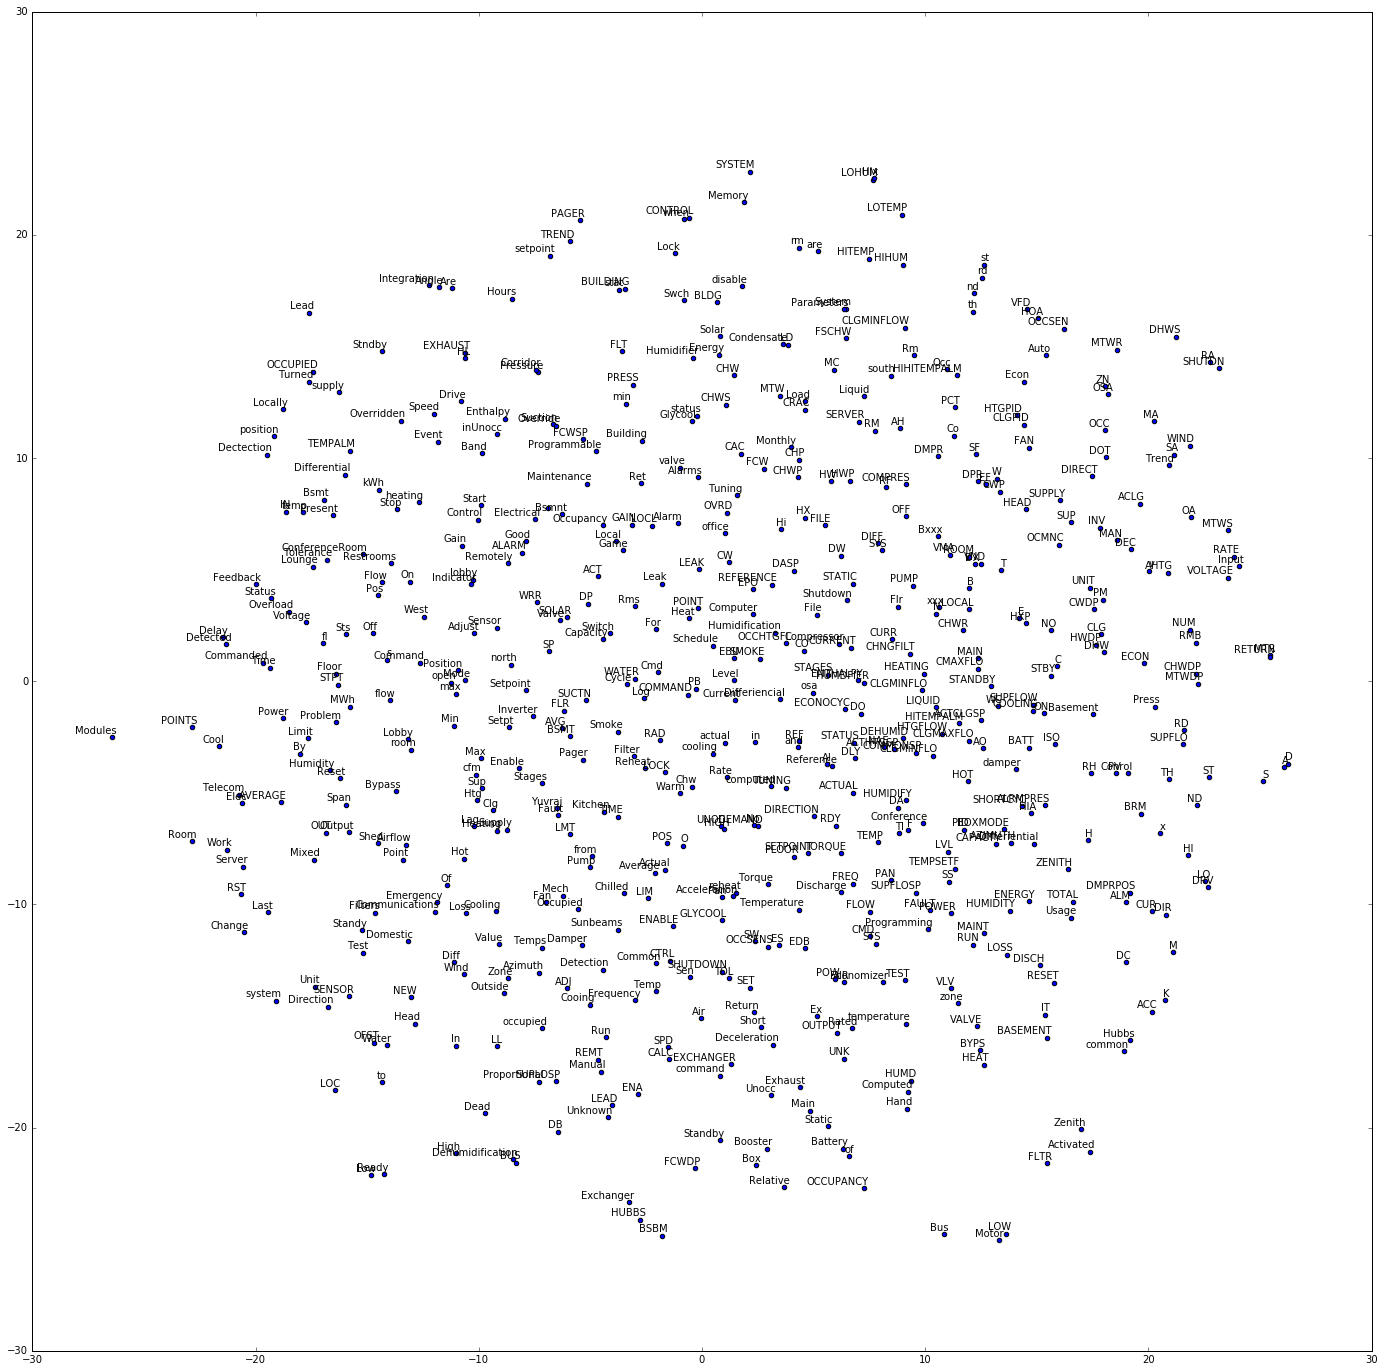

In [27]:
### Visualization of learnt points on embedding map.
from sklearn.manifold import TSNE

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(24, 24))  #in inches
    for i, label in enumerate(labels):
        if label.lower() in relTypeWordDF['word'].tolist():
            #print "RED"
            c = 'red'
        elif label.lower() in relNonTypeWordDF['word'].tolist():
            #print "BLUE"
            c = 'blue'
        else:
            c = 'black'
        label = label.replace('jciname_','')
        label = label.replace('name_','')
        label = label.replace('desc_','')
            
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                    color=c)

    #plt.savefig(filename)

try:
    #import matplotlib
    #reload(matplotlib)
    #matplotlib.use('Agg')
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    %matplotlib inline
    

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = vocabulary_size
    low_dim_embs = tsne.fit_transform(embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)
except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")

In [28]:
cosineDistDict = defaultdict(dict)
for i in range(0,len(embeddings)):
    for j in range(i+1, len(embeddings)):
        dist = spatial.distance.cosine(embeddings[i], embeddings[j])
        cosineDistDict[i][j] = dist
        cosineDistDict[j][i] = dist

In [29]:
print embeddings[dictionary['RM']]

[-0.24086072 -0.03226486 -0.22330776  0.04355669 -0.16313906 -0.2114739
  0.11189647  0.01802441  0.08371772  0.07553309 -0.14322248  0.08517148
 -0.08969835 -0.13669327  0.04603912  0.02423864  0.21771583  0.01791104
  0.04650396 -0.19481789  0.09031226 -0.08535525  0.02566395 -0.04194762
  0.06238952 -0.05381132 -0.1283574   0.00282353  0.09165365  0.0700216
  0.23252347  0.23378123  0.03858519  0.16811787  0.01121057 -0.20438692
 -0.03739644  0.09970737 -0.0939492   0.02240456 -0.03338945 -0.09415451
 -0.22265793 -0.04586212  0.0581666   0.22669733  0.03947929 -0.27905679
 -0.09602056 -0.08894799 -0.15366538  0.02457902  0.21063648 -0.01389496
 -0.03958088  0.02816508 -0.05735194 -0.02595638 -0.24114859  0.03072095
 -0.07496096  0.04473746  0.10528398  0.16083179]


In [30]:
i = 10
j = cosineDistDict[i].values().index(min(cosineDistDict[i].values()))
print j
print cosineDistDict[i][j]
print reverse_dictionary[i]
print reverse_dictionary[j]

for i in range(0, len(embeddings)):
    minVal = min(cosineDistDict[i].values())
    minIdx = cosineDistDict[i].values().index(minVal)
    minKey = cosineDistDict[i].keys()[minIdx]
    dist = cosineDistDict[i][minKey]
    if dist <= 0.4:
        print reverse_dictionary[i], reverse_dictionary[minKey], dist

59
0.516566844769
Command
Clg
NAE VMA 0.31763116893
B VMA 0.384860602651
N VMA 0.14455269044
EBU VMA 0.37547643477
VMA N 0.14455269044
RM CRAC 0.362751722336
Command Position 0.374228067558
Cooling Heating 0.328108251095
Occupied Damper 0.383760438414
OCC ZN 0.354643404484
VND N 0.296881139278
ZN OCC 0.354643404484
SUP SUPPLY 0.353853958386
CLGPID HTGPID 0.319444377389
ACTCLGSP CLGMiNFLO 0.306907832623
W DPR 0.286979769108
COMMONSP CLGMiNFLO 0.328505456448
DPR W 0.286979769108
Damper Occupied 0.383760438414
CLGMAXFLO ACTHTGSP 0.346781888796
RH ISO 0.394454181194
CLGMiNFLO ACTCLGSP 0.306907832623
Heating Cooling 0.328108251095
ACTHTGSP CLGMAXFLO 0.346781888796
HTGPID CLGPID 0.319444377389
SF RF 0.278858499459
Position Command 0.374228067558
CRAC SF 0.359362721443
RF SF 0.278858499459
DX VMA 0.267500634789
High Low 0.375023081896
F TEMPSETF 0.362661692462
Low High 0.375023081896
HUBBS BSBM 0.359981617926
SUPPLY SUP 0.353853958386
TEMPSETF F 0.362661692462
CAPACTY F 0.365073994985
BSBM HU

In [52]:
print type(embeddings)
pcaEmbedding = PCA(n_components=10)
decEmbedding = pcaEmbedding.fit_transform(np.asmatrix(embeddings))

<type 'numpy.ndarray'>


In [59]:
word1 = 'vma'
word2 = 'zn'
word3 = 'vfd'
word4 = 'direct'
print decEmbedding[dictionary[word2]] - decEmbedding[dictionary[word1]]
print decEmbedding[dictionary[word4]] - decEmbedding[dictionary[word3]]
print spatial.distance.cosine(decEmbedding[dictionary[word3]], decEmbedding[dictionary[word1]])
print spatial.distance.cosine(decEmbedding[dictionary[word4]], decEmbedding[dictionary[word2]])

[ -2.35160887e-02   3.44078898e-01  -5.37975430e-02  -4.89900649e-01
   1.12563372e-04  -4.33718786e-02   2.45137382e-02  -1.42227203e-01
   1.06214628e-01   5.73409721e-03]
[-0.01339962 -0.06660658 -0.33207706  0.13514753  0.04301278  0.36814705
  0.06902047 -0.16312303  0.17755346  0.08073723]
0.421085889174
0.98363688852


In [31]:
print dictionary.keys()

['DHWS', 'STANDBY', 'Leak', 'Time', 'HUMDFIER', 'Cooling', 'GAIN', 'DEMAND', 'osa', 'Cooing', 'DIRECTION', 'Lead', 'POWER', 'ECONOCYC', 'DMPR', 'Monthly', 'th', 'Unknown', 'HUMIDIFY', 'SPD', 'Present', 'Elec', 'SUPPLY', 'CURRENT', 'WRR', 'Discharge', 'RUN', 'room', 'Reference', 'ACLG', 'REMT', 'ENTHALPY', 'WATER', 'damper', 'Cool', 'MAN', 'cfm', 'Tuning', 'MAINT', 'CMD', 'PCT', 'Remotely', 'CLGMINFLO', 'Bypass', 'Head', 'TUNING', 'Game', 'MTWR', 'MTWS', 'VLV', 'ZN', 'Short', 'Yuvraj', 'K', 'Heating', 'STBY', 'Commanded', 'AHTG', 'Shed', 'MA', 'zone', 'MC', 'INV', 'Dead', 'HUMIDITY', 'PUMP', 'Voltage', 'Motor', 'CHWDP', 'FLT', 'Conference', 'OVRD', 'STPT', 'Input', 'REF', 'DOT', 'Status', 'HTGPID', 'FCW', 'SUPFLO', 'ES', 'OUT', 'HITEMP', 'Exchanger', 'F', 'AVERAGE', 'Cmd', 'UNOC', 'Sts', 'EDB', 'LOSS', 'ALM', 'Feedback', 'Supply', 'SS', 'SP', 'LMT', 'ST', 'ACTHTGSP', 'HUMD', 'v', 'SA', 'SF', 'TEMPSETF', 'DPR', 'Min', 'HIx', 'Valve', 'Integration', 'TOL', 'CAC', 'LD', 'COMMONSP', 'TREND'

In [32]:
print len(embeddings)
print embeddings[0]
print dictionary['HXP']
print reverse_dictionary[1]


582
[ 0.03836824 -0.01762095  0.05133778 -0.10310157 -0.21223995 -0.0334875
  0.11107638  0.03543892  0.07491451 -0.11156339 -0.18849781  0.13927032
  0.03812047 -0.19577815 -0.00935315  0.04794845  0.19404018 -0.21364652
  0.17560697 -0.17709859  0.03195453 -0.00667825  0.01158703 -0.0968847
 -0.02468726 -0.06264966  0.08303876 -0.20849401  0.13794611 -0.09407208
  0.25345945  0.08715864 -0.12979285 -0.10064425  0.09061809  0.01594933
  0.20357138 -0.0967539  -0.02824658 -0.03815083  0.20565875  0.02142014
 -0.20291111  0.15550123 -0.06898946  0.04124044  0.14562389 -0.00486248
  0.03803197 -0.0790031  -0.06392413 -0.14585993  0.22566038 -0.0429863
  0.10939698 -0.14627498 -0.17885742  0.07179485  0.03259039 -0.13041848
  0.06240341  0.21069764  0.16261898  0.16095632]
537
NUM


In [25]:
assert(False)
dtc = DecisionTreeClassifier()
learnIndices = random.sample(range(0,len(subEntropyDF.index)), len(subEntropyDF.index)/3)
learnWordList = subEntropyDF.iloc[learnIndices].index
testWordList = deepcopy(subEntropyDF.index).tolist()
for word in learnWordList:
    testWordList.remove(word)
wordroleSeries = wordroleDF.loc[learnWordList]
#wordroleList = [1 if role.lower()=='o' else 0 for role in wordroleSeries]
dtc.fit(subEntropyDF.loc[learnWordList], wordroleSeries)
predResult = dtc.predict(subEntropyDF.loc[testWordList])
#print testWordList
truthList = wordroleDF.loc[testWordList]['type word?']
precision = float(sum([1 if i==j else 0 for i, j in zip(predResult, truthList)]))/float(len(truthList))
print precision

AssertionError: 

In [ ]:
##Print discretization result
%matplotlib inline
oneFigLen = 500
colorList = [np.random.rand(3,1) for i in range(0,clusterNum)]
for featType, featSeries in featureDF.iteritems():
    print featType
    localFeatDict = featSeries.to_dict()
    sortedFeatDict = OrderedDict(sorted(localFeatDict.items(), key=operator.itemgetter(1)))
    localLabelDict = predLabelDF[featType].to_dict()
    
    
    fig = plt.figure(figsize=(60,5))
    xticks = list()
    xtickLabels = list()
    ax = fig.add_subplot(111)
    filename = 'figs/'+buildingName+'_clustering_'+featType+'_total.pdf'
    x = list()
    y = list()
    c = list()
    for srcid, feat in sortedFeatDict.iteritems():
        pointType = truthDF.loc[srcid]['Ground Truth Point Type']
        label = localLabelDict[srcid]
        x.append(feat)
        y.append(localLabelDict[srcid])
        c.append(colorList[localLabelDict[srcid]])
        #ax.scatter([np.log(feat)], [localLabelDict[srcid]], color=colorList[localLabelDict[srcid]])
        xticks.append(feat)
        xtickLabels.append(pointType)
        
    ax.scatter(x=x,y=y,c=c)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickLabels, rotation='vertical')
    ax.set_xlabel('point type')
    ax.set_ylabel('discretization result')
    #ax.set_ylim((0.9,1.1))
    #plt.show()
    #plt.savefig(filename, dpi=1000)
    save_fig(fig, filename, dpi=1000)
    
    print featType
    
    i = 0
    for srcid, feat in sortedFeatDict.iteritems():
        if i%oneFigLen == 0 :
            print i
            fig = plt.figure(figsize=(60,4))
            ax = fig.add_subplot(111)
            filename = 'figs/'+buildingName+'_clustering_'+featType+'_'+str(i)+'.png'
            xticks = list()
            xtickLabels = list()
            x = list()
            y = list()
            c = list()
        pointType = truthDF.loc[srcid]['Ground Truth Point Type']
        x.append(feat)
        y.append(localLabelDict[srcid])
        c = colorList[localLabelDict[srcid]]
        #ax.scatter([feat], [1], color=colorList[localLabelDict[srcid]])
        xticks.append(feat)
        xtickLabels.append(pointType)
                   
        if (i)%oneFigLen==oneFigLen-1:
            ax.scatter(x=x, y=y, c=c)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtickLabels, rotation='vertical')
            ax.set_ylim((0.9,1.1))
            #save_fig(fig, filename, dpi=5000)
            plt.savefig(filename, dpi=1000)
            print i
        i += 1
  

In [ ]:
########################################## VISUALIZATION
####################### Draw figures of features per word
matplotlib.use('Agg')

def figure_global_features():
    fig = plt.figure(figsize=(10,12))
    axList = list()
    for i in range(0,len(featureDF.keys())):
        axList.append(fig.add_subplot(len(featureDF.keys()),1,i+1))
    for ax, (featType, featSeries) in zip(axList, featureDF.iteritems()):
        yList = [random.random()*2 for i in range(len(featSeries))]
        ax.scatter(featSeries, yList, alpha=0.3, s=5)
        ax.set_title(featType)
        ax.set_ylabel("Just Random")
    return fig, axList

#fig, axList = figure_global_features()
#plt.show()    
skipFlag = True
for bowType, bow in bowDict.iteritems():
#bowType = 'desc'
#for bow in [bowDict[bowType]]:
    vect = vectDict[bowType]
    for idx in range(0,bow.get_shape()[1]):
        print idx
        #localFig = copy(fig)
        #print localFig
        #localAxList = copy(axList)
        indices = bow.getcol(idx).nonzero()[0]
        srcidList = [sensor_list[i]['source_id'] for i in indices]
        zeroArr = np.zeros(bow.shape[1])
        sentence = zeroArr
        sentence[idx] = 1
        word = vect.inverse_transform(sentence)[0][0]
        if bowType=='jciname' and word=='vma119':
            skipFlag = False
            continue
        if skipFlag:
            continue
        print word
        localFig, localAxList = figure_global_features()
        filename = 'figs/' + buildingName + '/'+'feat_comp_' + bowType + '_'+ word + '.png'
        subDF = featureDF.loc[srcidList]
        for ax, (featType, featSeries) in zip(localAxList, subDF.iteritems()):
            yList = [random.random()*2 for i in range(len(featSeries))]
            ax.scatter(featSeries, yList, alpha=0.5, marker='x', c='red')
        #save_fig(localFig, filename, dpi=400)
        plt.savefig(filename)#, format='png', dpi=200)
        
        

In [ ]:
########################################## VISUALIZATION
####################### Draw figures of DISCRETIZATION per word
matplotlib.use('Agg')

def figure_global_discretization():
    fig = plt.figure(figsize=(10,12))
    axList = list()
    for i in range(0,len(featureDF.keys())):
        axList.append(fig.add_subplot(len(featureDF.keys()),1,i+1))
    for ax, (featType, featSeries) in zip(axList, featureDF.iteritems()):
        ax.plot(globalCntDict[featType].values())
        ax.set_title(featType)
    return fig, axList

fig, axList = figure_global_discretization()
plt.show()    

skipFlag = True
for bowType, bow in bowDict.iteritems():
#bowType = 'desc'
#for bow in [bowDict[bowType]]:
    vect = vectDict[bowType]
    for idx in range(0,bow.get_shape()[1]):
        indices = bow.getcol(idx).nonzero()[0]
        srcidList = [sensor_list[i]['source_id'] for i in indices]
        zeroArr = np.zeros(bow.shape[1])
        sentence = zeroArr
        sentence[idx] = 1
        word = vect.inverse_transform(sentence)[0][0]
        if not '163' in word:
            continue
        localFig, localAxList = figure_global_discretization()
        
        filename = 'figs/' + buildingName + '/'+'discretization_comp_' + bowType + '_'+ word + '.png'
        subDF = predLabelDF.loc[srcidList]
        for ax, (featType, labelSeries) in zip(localAxList, subDF.iteritems()):
            ax2 = ax.twinx()
            labelCounter = Counter(labelSeries)
            labelCntDict = OrderedDict((key, labelCounter[key]) for key in keyLabels)
            ax2.plot(labelCntDict.values(), color='red')
        #save_fig(localFig, filename, dpi=400)
        plt.savefig(filename)#, format='png', dpi=200)
        plt.clf()
        print word
        
        

In [ ]:
########################################## VISUALIZATION
####################### Draw figures of ENTROPY per word    

for bowType, bow in bowDict.iteritems():
#bowType = 'desc'
#for bow in [bowDict[bowType]]:
    vect = vectDict[bowType]
    for idx in range(0,bow.get_shape()[1]):
        localFig = plt.figure(figsize=(6,4))
        ax = localFig.add_subplot(111)
        zeroArr = np.zeros(bow.shape[1])
        sentence = zeroArr
        sentence[idx] = 1
        word = vect.inverse_transform(sentence)[0][0]
        filename = 'figs/' + buildingName + '/'+'entropy_comp_' + bowType + '_'+ word + '.png'
        indices = range(0,len(globalEntropyDict))
        ax.bar(indices, globalEntropyDict.values(), width=0.35)
        indices = [i+0.35 for i in indices]
        ax.bar(indices, entropyDict[bowType][idx].values(), width=0.35, color='red')
        ax.set_xticks(indices)
        ax.set_xticklabels(globalEntropyDict.keys(), rotation=90)
        #save_fig(localFig, filename, dpi=400)
        #plt.show()
        plt.savefig(filename)#, format='png', dpi=200)
        print word       
        